# Looking at the geometries of tracks (angle, length)

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
import os
import sys

sys.path.append("../lib/TrackObs/")
sys.path.append("../lib/CosmicObservation/")

from CosmicObservation import *
from external_flux import *
from astropy.io import fits

import glob
import re

In [3]:
getobmt = lambda x: int(re.search("(?<=OBMT_START_)[0-9]+",x).group(0))

In [4]:
# get all paths
smpaths = glob.glob("../output/CosmicObservations/*/*/*/SM-SIF_OBMT_START_*.fits")
smpaths.sort(key = getobmt)

bamobspaths = glob.glob("../output/CosmicObservations/*/*/*/BAM-OBS*_OBMT_START_*.fits")
bamobspaths.sort(key = getobmt)

bamsifpaths = glob.glob("../output/CosmicObservations/*/*/*/BAM-SIF_OBMT_START_*.fits")
bamsifpaths.sort(key = getobmt)

In [5]:
def psel_obmt(allpaths,start,stop):
    pathtimes = np.array([getobmt(p) for p in allpaths])
    indices = np.where(np.logical_and(pathtimes>=start, pathtimes<=stop))[0]
    return [allpaths[ii] for ii in indices]

def psel_rev(allpaths,start,stop):
    pathtimes_rev = np.array([getobmt(p) for p in allpaths])/(1e9*3600*6)
    indices = np.where(np.logical_and(pathtimes_rev>=start, pathtimes_rev<=stop))[0]
    return [allpaths[ii] for ii in indices]


def psel_mjd(allpaths,start,stop):
    pathtimes_mjd = OBMT_apyTime(np.array([getobmt(p) for p in allpaths])).mjd
    indices = np.where(np.logical_and(pathtimes_mjd>=start, pathtimes_mjd<=stop))[0]
    return [allpaths[ii] for ii in indices]

# Choosing source and time ranges

In [6]:
# SM
#bin_AL = 2
#bin_AC = 2
#pixdepth = 12  # depletion zone depth in mum

#obslist = read_CosObs_fits(sorted(glob.glob('../output/CosmicObservations/2017/07/*/SM-SIF*.fits')))



# BAM
bin_AL = 1
bin_AC = 4
pixdepth = 38  # depletion zone depth in mum

## full revolutions in BAM
# big flare tail
#obslist = (read_CosObs_fits('../output/CosmicObservations/2017/09/12/BAM-OBS1_OBMT_START_122186884743079104.fits')
#         + read_CosObs_fits('../output/CosmicObservations/2017/09/12/BAM-OBS1_OBMT_START_122198643945079104.fits'))

#obslist = (read_Obslist_fits('../output/CosmicObservations/2017/09/12/BAM-OBS2_OBMT_START_122186884736199504.fits')
#         + read_Obslist_fits('../output/CosmicObservations/2017/09/12/BAM-OBS2_OBMT_START_122198643938199504.fits')

#obslist = obslist[:940]

# quiet time                       
obslist = (read_CosObs_fits('../output/CosmicObservations/2017/07/03/BAM-OBS1_OBMT_START_116049958174360704.fits')
         + read_CosObs_fits('../output/CosmicObservations/2017/07/03/BAM-OBS1_OBMT_START_116061717376360704.fits'))

#obslist = (read_CosObs_fits('../output/CosmicObservations/2017/07/03/BAM-OBS2_OBMT_START_116049958167481104.fits')
#         + read_CosObs_fits('../output/CosmicObservations/2017/07/03/BAM-OBS2_OBMT_START_116061717369481104.fits'))

obslist = obslist[:940]



# BAM-SIF
#bin_AL = 1
#bin_AC = 4
#pixdepth = 38  # depletion zone depth in mum
    
#obslist = read_CosObs_fits(sorted(glob.glob('../output/CosmicObservations/2017/07/*/BAM-SIF*.fits')))


print('Nr. Observations:',len(obslist))

Nr. Observations: 940


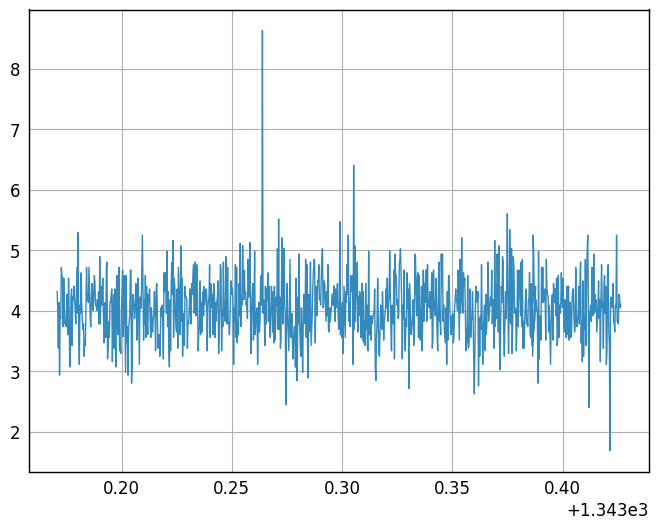

In [7]:
plt.plot([o.acqTime/1e9/24/3600 for o in obslist], [o.flux for o in obslist])

# Get the geometries

In [8]:
theta = []
sd_theta = []
length = []
sd_length = []
energies = []

badtracks = []

#cutoffs = (6,3)
#cutoffs = (10,10)
import time

t0 = time.time()
for obs in obslist:   
    valid = obs.data['GEOMETRY_VALID']
    theta+=(list(obs.data['TRACK_THETA'][valid]))
    sd_theta+=(list(obs.data['TRACK_THETA_ERR'][valid]))
    length+=(list(obs.data['TRACK_LEN'][valid]))
    sd_length+=(list(obs.data['TRACK_LEN_ERR'][valid]))
    energies+=(list(obs.data['TRACK_EN'][valid]))
        
theta = np.array(theta)
sd_theta = np.array(sd_theta)
length = np.array(length)
sd_length = np.array(sd_length)
energies = np.array(energies)

print("Processing took", time.time()-t0, 's')

nparticles = np.sum([len(o.data) for o in obslist])
print("Using {} of {} particles ({} %)".format(len(theta),nparticles,len(theta)/nparticles*100))

Processing took 0.02216958999633789 s
Using 20129 of 85566 particles (23.52453077156815 %)


# Histograms

(-90, 90)

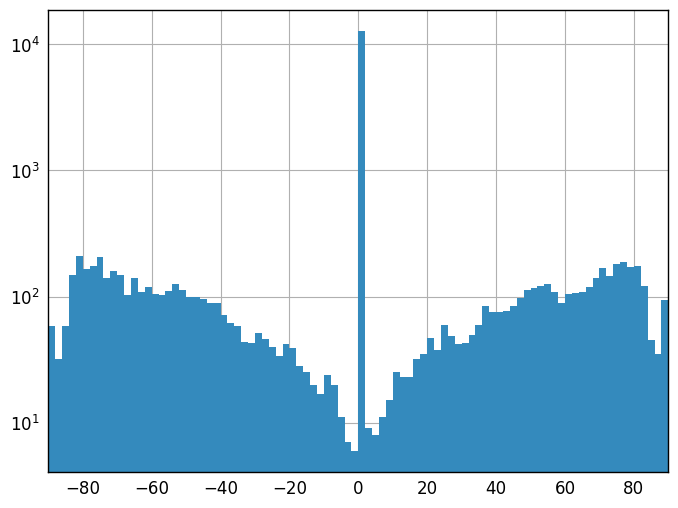

In [43]:
testhist = plt.hist(theta, 90, range=(-90,90),log=True)
plt.xlim(-90,90)
#plt.ylim(0,4e2)

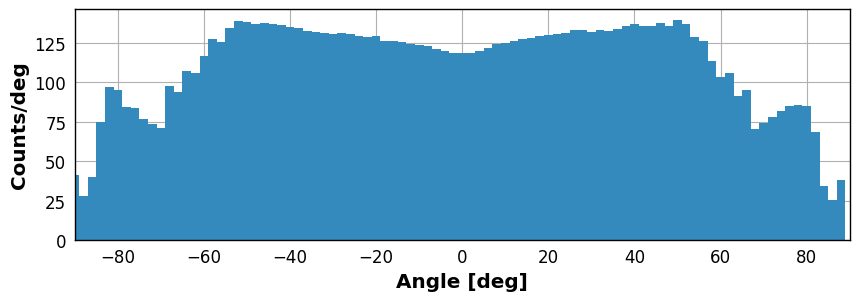

In [44]:
# an angular histogram that spreads each angle out according to its error

nbins = 90
bin_lo = np.linspace(-90,90,nbins,endpoint=False)
vals = np.zeros(len(bin_lo))
bin_width = bin_lo[1]-bin_lo[0]

minvals = theta-sd_theta
maxvals = theta+sd_theta

minvals = minvals[sd_theta>0]
maxvals = maxvals[sd_theta>0]

for ii in range(len(minvals)):
    add_range = np.logical_and(bin_lo+bin_width >= minvals[ii], bin_lo <= maxvals[ii])
    if maxvals[ii] > 90:
        add_range += bin_lo <= maxvals[ii]-180
    if minvals[ii] < -90:
        add_range += bin_lo+bin_width >= minvals[ii]+180
    
    vals[add_range] += 1/np.sum(add_range)

    
norm = bin_width
plt.bar(bin_lo, vals/norm, width=bin_width,log=False)
plt.ylabel("Counts/deg")
plt.xlabel("Angle [deg]")
plt.xlim(-90,90)
#plt.ylim(0,1400)

plt.gcf().set_size_inches(10,3)
#plt.savefig('../../presentation_imgs/anglehist_normal.pdf',bbox_inches='tight')

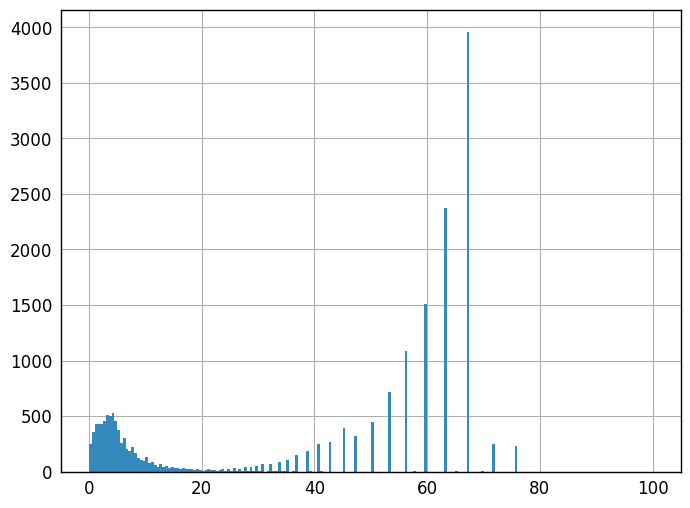

In [45]:
testhist = plt.hist(sd_theta,200,range=(0,100))

Two components here: The high and frequent ones with regular spacing are particles with dim_AC = 1 (manual uncertainty calc.)

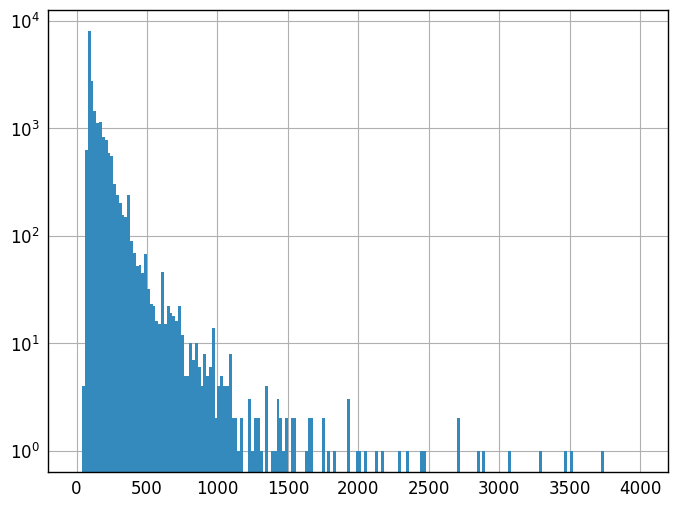

In [46]:
testhist = plt.hist(length, 200,log=True,range=(0,4000))

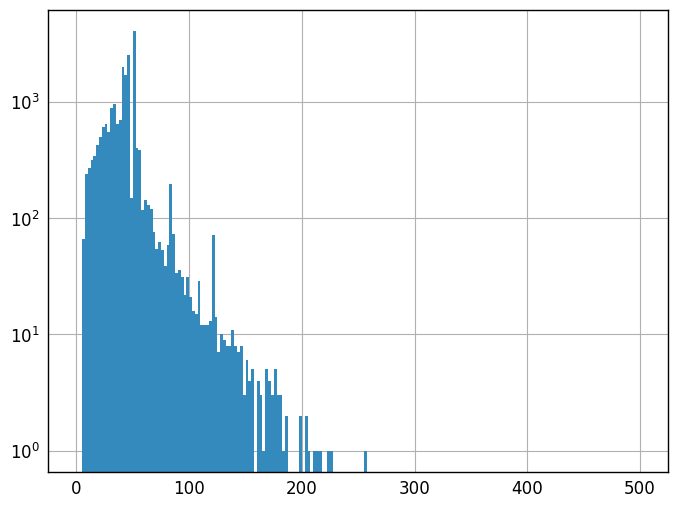

In [14]:
testhist = plt.hist(sd_length, 200,log=True,range=(0,500))

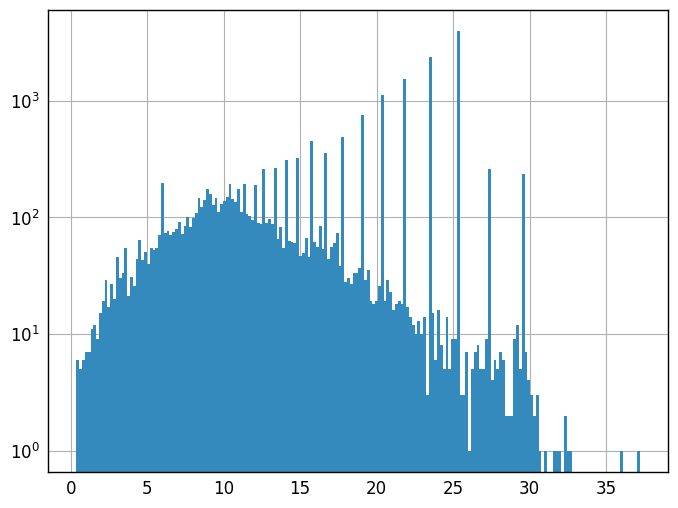

In [15]:
alpha_entr = np.arctan(pixdepth/length)*180/np.pi
athist = plt.hist(alpha_entr, 200,log=True)

(-500, 10000)

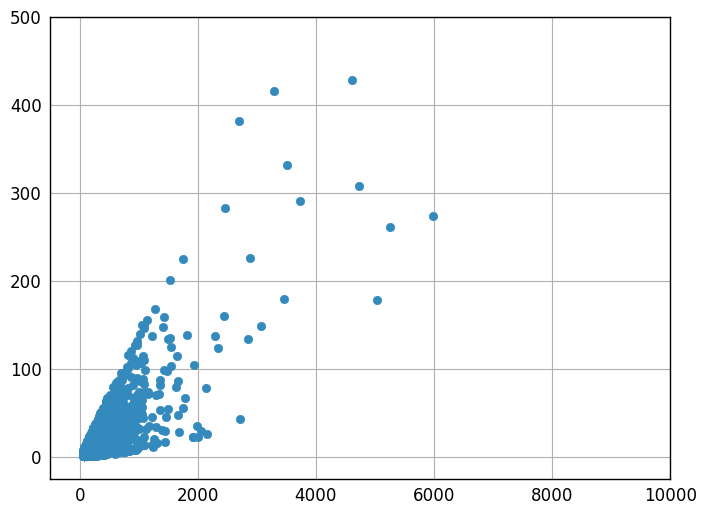

In [16]:
plt.scatter(length,length/sd_length)
plt.ylim((-25,500))
plt.xlim((-500,10000))

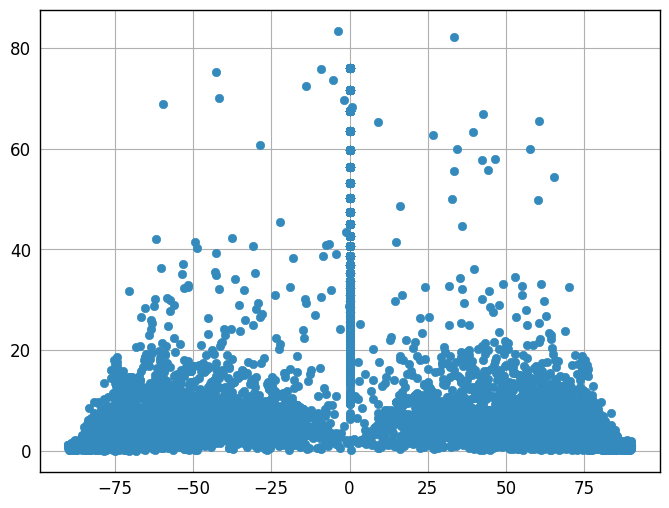

In [17]:
plt.scatter(theta,sd_theta)
#plt.ylim(-5,95)

# Angular length histogram (Lengths per angle)

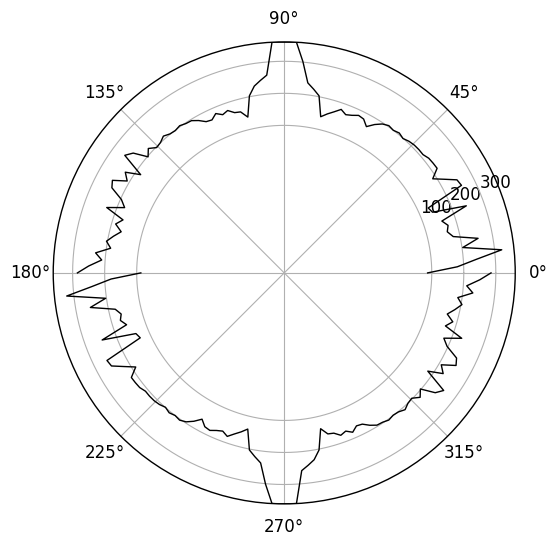

In [18]:
theta_binning = np.copy(theta)
theta_binning[theta<0] += 180

alpha = np.linspace(0,180,90)
da = alpha[1]-alpha[0]
bin_lo = alpha-da/2

medrad = np.zeros(alpha.shape[0])


for ii in range(len(alpha)):
    bin_indices = np.logical_and(theta_binning>=bin_lo[ii], theta_binning<bin_lo[ii]+da)
    # let's also introduce a length filter
    medrad[ii] = np.median((length)[np.logical_and(bin_indices,length>0)])
    # also interesting:
    #medrad[ii] = np.median((length/sd_length)[np.logical_and(bin_indices,length>0)])
    
    
    
#medrad/=pixlen # normalize by length per pixel in that particular direction


# set alpha for plotting
alpha = alpha*np.pi/180
for ii in range(2):
    plt.polar((alpha+ii*np.pi), medrad, color='k')
    

maxrad = np.nanmax(medrad)
minrad = np.nanmin(medrad)

plotrad = np.nanmax(medrad)
plt.xlim((-plotrad,plotrad))
plt.ylim((-plotrad,plotrad))
plt.gca().set_aspect(1)

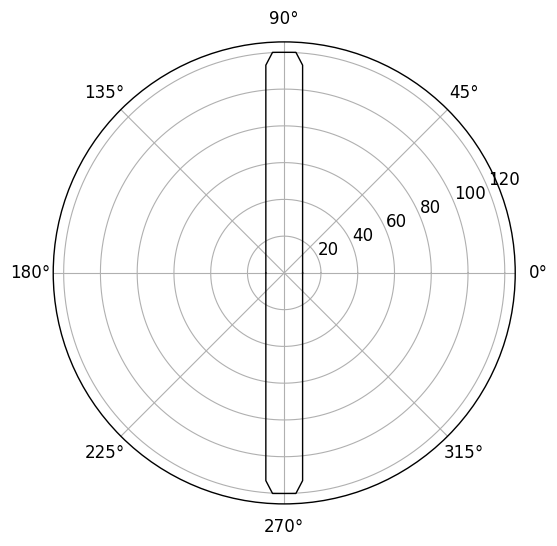

In [19]:
thetacrit = np.arctan(3*bin_AC / (bin_AL))

alpha = np.linspace(0,np.pi,90)

pixlen = np.zeros(alpha.shape)
shortax = np.logical_or(np.abs(alpha)<=thetacrit, np.abs(alpha)>=np.pi-thetacrit)
longax = np.logical_and(np.abs(alpha)>thetacrit, np.abs(alpha)<np.pi-thetacrit)

pixlen[shortax] = 10 * bin_AL / np.cos(np.abs(alpha[shortax]))
pixlen[longax]  = 30 * bin_AC / np.sin(np.abs(alpha[longax]))

pixlen = np.abs(pixlen)


for ii in range(2):
    plt.polar((alpha+ii*np.pi), pixlen, color='k')
    
plt.xlim(-60,60)

... makes sense

# dE/dx

While histograms over individual tracks don't really give good results, how about just using the average dE/dx?

In [10]:
dEdx = np.array(energies)*3.68/length/100/2.32  # Not using depth here

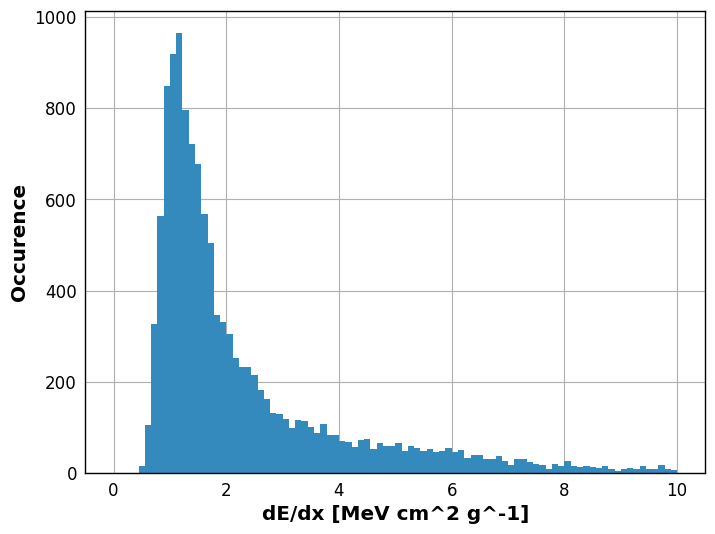

In [11]:
testhist = plt.hist(dEdx[theta==0],90,log=False,range=(0,10))
#testhist = plt.hist(dEdx,90,log=False,range=(0,20))
#plt.ylim(0,40)
#plt.ylim(0,1700)
#plt.ylim(0,600)
plt.xlabel("dE/dx [MeV cm^2 g^-1]")
plt.ylabel("Occurence")

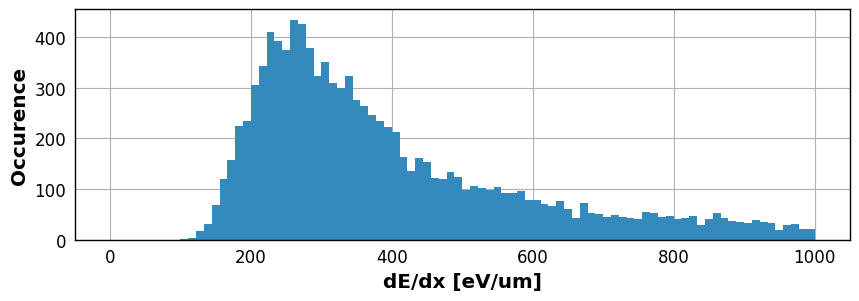

In [12]:
dEdx = np.array(energies)*3.68/length  # Not using depth here
testhist = plt.hist(dEdx[theta==0],90,log=False,range=(0,1000))
#plt.ylim(0,40)
#plt.ylim(0,1700)
#plt.ylim(0,600)
plt.xlabel("dE/dx [eV/um]")
plt.ylabel("Occurence")
plt.gcf().set_size_inches(10,3)
#plt.savefig('../../presentation_imgs/dEdx_normal_zoom.pdf',bbox_inches='tight')

In [14]:
np.mean(dEdx)

778.27767386070525

-> For SM: During quiescence, there is a single peak at about MIP energy. During the flare however, there is a lot of stuff at a higher dE/dX, as you'd expect from lower energy solar particles!

While we're at geometry: What if I histogram, say, the nr. of pixels per tracks vs their energy?

In [80]:
ecos = []
nn = []
lal = []
lac = []

for obs in obslist:
    for ii in range(len(obs.data)):
        nn.append(obs.data['TRACK_NPIX'][ii])
        ecos.append(obs.data['TRACK_EN'][ii])
        lal.append(obs.data['DIM_AL'][ii])
        lac.append(obs.data['DIM_AC'][ii])

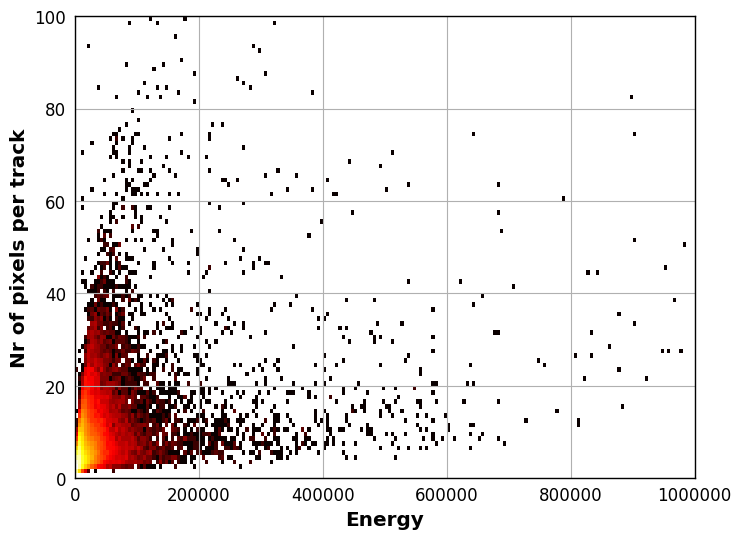

In [81]:
testhist = plt.hist2d(ecos,nn,bins=(200,100),cmap='hot',range=[[0,1000000],[0,100]],norm=LogNorm())
plt.xlabel('Energy')
plt.ylabel('Nr of pixels per track')